# Constraining subglacial processes from surface velocity observations using surrogate-based Bayesian inference
## Part 1 - Training an ensemble of neural networks

In this notebook, we will illustrate the process of using Bayesian Bootstrap Aggregation (BayesBag) to train an ensemble of neural networks.  In this case, each ensemble member is one possible surrogate for the coupled hydrology-ice dynamics model described in the paper, mapping from a vector of 8 parameters to a velocity field.  We begin by importing both the parameters and the associated velocity fields computed by the physics model, which will act as training data for the surrogate.

In [1]:
import pickle
import numpy as np
import re
#import utilities
import xarray as xr

thin = 1

o_file = "/Volumes/zachariae/pism-gris/data_sets/velocities/measures/greenland_vel_mosaic250_v1_g1800m.nc"
o_xr = xr.open_dataset(o_file)

o_speed = o_xr.variables["velsurf_mag"].values[::thin,::thin]
o_speed_sigma = o_xr.variables["velsurf_mag_error"].values[::thin,::thin]

o_ny, o_nx = o_speed.shape
o_xr.close()

o_speeds = np.nan_to_num(o_speed, 0).reshape(-1, 1)
o_log_speeds = np.log10(o_speeds)
o_log_speeds[np.isneginf(o_log_speeds)] = 0

o_speeds_sigma = np.nan_to_num(o_speed_sigma, 0).reshape(-1, 1)

from glob import glob
s_files = glob("../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_*_0_50.nc")
nt = len(s_files)

# open first file to get the dimensions
vxr0 = xr.open_dataset(s_files[0])
speed = vxr0.variables["velsurf_mag"].values[:,::thin,::thin]
_, ny, nx = speed.shape
vxr0.close()

m_speeds = np.zeros((nt, ny * nx))

# Go through all files and don't forget to extract the experiment id
ids = []
for k, s_file in enumerate(s_files):
    print(f"Reading {s_file}")
    vxr = xr.open_dataset(s_file)
    ids.append(re.search("id_(.+?)_0", s_file).group(1))
    m_speeds[k, ::] = vxr.variables["velsurf_mag"].values[:,::thin,::thin].flatten()
    vxr.close()

# For comparison, we run the analysis for both u and log10(u)
m_speeds_mean = np.nanmean(m_speeds, axis=0)
m_speeds_anom = m_speeds - m_speeds_mean
m_speeds_anom = np.nan_to_num(m_speeds_anom, 0)

m_log_speeds = np.log10(np.nan_to_num(m_speeds, 0))
m_log_speeds[np.isneginf(m_log_speeds)] = 0
m_log_speeds_mean = np.nanmean(m_log_speeds, axis=0)
m_log_speeds_anom =  m_log_speeds - m_log_speeds_mean
m_log_speeds_anom[np.isneginf(m_log_speeds_anom)] = 0
m_log_speeds_anom = np.nan_to_num(m_log_speeds_anom, 0)

/var/folders/5g/4lg4tzwn1_d4x1q5t32_wrl80000gn/T/ipykernel_69757/3315067565.py:19: RuntimeWarning: divide by zero encountered in log10
  o_log_speeds = np.log10(o_speeds)


Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_586_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_596_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_51_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_854_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_41_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_844_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_9_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_798_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_788_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_995_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_174_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_985_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_164_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_659_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4

Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_946_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_956_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_494_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_484_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_555_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_545_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_278_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_300_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_268_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_310_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_887_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_82_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_897_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_92_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_

Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_191_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_970_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_525_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_535_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_208_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_370_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_218_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_360_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_643_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_653_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_936_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_926_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_782_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_3_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_

Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_356_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_346_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_98_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_104_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_88_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_114_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_629_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_751_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_639_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_741_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_437_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_427_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_262_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_272_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_

Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_254_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_122_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_132_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_777_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_767_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_233_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_223_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_466_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_476_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_678_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_700_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_668_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_710_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_155_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800

Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_215_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_205_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_538_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_440_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_528_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_450_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_612_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_602_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_259_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_321_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_249_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_331_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_574_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_564_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800

Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_552_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_634_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_624_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_119_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_880_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_85_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_890_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_109_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_95_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_290_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_280_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_917_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_907_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_662_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_

Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_998_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_785_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_795_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_4_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_849_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_931_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_859_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_921_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_805_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_10_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_815_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_382_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_392_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_243_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v

Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_548_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_430_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_558_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_420_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_489_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_499_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_697_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_687_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_26_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_823_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_36_0_50.nc
Reading ../data/speeds_v2/velsurf_mag_gris_g1800m_v4_id_833_0_50.nc


/var/folders/5g/4lg4tzwn1_d4x1q5t32_wrl80000gn/T/ipykernel_69757/3315067565.py:50: RuntimeWarning: divide by zero encountered in log10
  m_log_speeds = np.log10(np.nan_to_num(m_speeds, 0))


In [2]:
import pandas as pd
response_file = "log_speeds.csv"
df = pd.DataFrame(data=m_log_speeds, index=ids)
print(df.head())
df.to_csv(response_file, index_label="id")

     0        1        2        3        4        5        6        7        \
586      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
596      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
51       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
854      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
41       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

     8        9        ...  1337590  1337591  1337592  1337593  1337594  \
586      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
596      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
51       0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
854      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
41       0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   

     1337595  1337596  1337597  1337598  1337599  
586      0.0      0.0  

In [ ]:
from pismemulator.utils import prepare_data
import pandas as pd
response_file = "log_speeds.csv"
samples_file = "../data/samples/velocity_calibration_samples_100.csv"
samples, response = prepare_data(samples_file, response_file)


Preparing sample ../data/samples/velocity_calibration_samples_100.csv and response log_speeds.csv


The velocity fields have some bad simulations in them, so we filter out circumstances in which the model never ran past 12 years, and in which the max velocity was greater than 100km/a.

In [ ]:
p = response.max(axis=1)<6

F = response[p].values
X = samples[p].values

Finally, we log transform the velocity fields.

We will use pytorch to construct and train the neural networks.  To this end, we will move the physical model's parameters and (log-)speed fields to pytorch, and use the GPU if it's available.

In [5]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

m = X.shape[0]

X = torch.from_numpy(X)
F = torch.from_numpy(F)
F[F<0] = 0

X = X.to(torch.float32)
F = F.to(torch.float32)

X = X.to(device)
F = F.to(device)

X_m = X.mean(axis=0)
X_s = X.std(axis=0)

#F_m = F.mean(axis=0)
#F_s = F.std(axis=0)

X = (X-X_m)/X_s
#F = (F-F_m)/(F_s + 1e-5)

#X_hat = torch.log10(X)

In [6]:
F.min()

tensor(0., device='cuda:0')

Part of our objective function is to weight by element area.  We will grab those values from a .vtu of an observed velocity field.

In [7]:
import pickle
import numpy as np
#u_obs = utilities.VData('./data/u_observed.vtu')
#point_area = torch.tensor(u_obs.get_point_area(),dtype=torch.float,device=device)
normed_area = torch.tensor(np.ones(F.shape[1]),device=device)
normed_area/=normed_area.sum()
print(normed_area)

tensor([1.8690e-05, 1.8690e-05, 1.8690e-05,  ..., 1.8690e-05, 1.8690e-05,
        1.8690e-05], device='cuda:0', dtype=torch.float64)


Next we need to define a few functions and classes.  First, we will create a function that extracts eigenglaciers and constructs the matrix $\hat{V}$, corresponding to the Dimensionality Reduction section.

In [8]:
def get_eigenglaciers(omegas,F,cutoff=0.999):
    F_mean = (F*omegas).sum(axis=0)
    F_bar = F - F_mean # Eq. 28
    Z = torch.diag(torch.sqrt(omegas.squeeze()*m))
    U,S,V = torch.svd_lowrank(Z@F_bar,q=100)
    lamda = S**2/(m) 
    #print(S.shape)

    #lamda, V = torch.eig(S,eigenvectors=True) # Eq. 26
    #lamda = lamda[:,0].squeeze()
    
    cutoff_index = torch.sum(torch.cumsum(lamda/lamda.sum(),0)<cutoff)
    lamda_truncated = lamda.detach()[:cutoff_index]
    V = V.detach()[:,:cutoff_index]
    V_hat = V @ torch.diag(torch.sqrt(lamda_truncated)) # A slight departure from the paper: Vhat is the
                                                        # eigenvectors scaled by the eigenvalue size.  This
                                                        # has the effect of allowing the outputs of the neural
                                                        # network to be O(1).  Otherwise, it doesn't make 
                                                        # any difference.
    return V_hat, F_bar, F_mean

Second, we define the architecture of the neural network to be used as a surrogate.  This corresponds to the architecture defined in Fig. 3.

In [9]:
import torch.nn as nn

class Emulator(nn.Module):
    def __init__(self,n_parameters,n_eigenglaciers,n_hidden_1,n_hidden_2,n_hidden_3,n_hidden_4,V_hat,F_mean):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.l_1 = nn.Linear(n_parameters, n_hidden_1)
        self.norm_1 = nn.LayerNorm(n_hidden_1)
        self.dropout_1 = nn.Dropout(p=0.0)
        self.l_2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.norm_2 = nn.LayerNorm(n_hidden_2)
        self.dropout_2 = nn.Dropout(p=0.5)
        self.l_3 = nn.Linear(n_hidden_2, n_hidden_3)
        self.norm_3 = nn.LayerNorm(n_hidden_3)
        self.dropout_3 = nn.Dropout(p=0.5)
        self.l_4 = nn.Linear(n_hidden_3, n_hidden_4)
        self.norm_4 = nn.LayerNorm(n_hidden_3)
        self.dropout_4 = nn.Dropout(p=0.5)
        self.l_5 = nn.Linear(n_hidden_4, n_eigenglaciers)

        self.V_hat = torch.nn.Parameter(V_hat,requires_grad=False)
        self.F_mean = torch.nn.Parameter(F_mean,requires_grad=False)

    def forward(self, x, add_mean=False):
        # Pass the input tensor through each of our operations

        a_1 = self.l_1(x)
        a_1 = self.norm_1(a_1)
        a_1 = self.dropout_1(a_1)
        z_1 = torch.relu(a_1) 

        a_2 = self.l_2(z_1)
        a_2 = self.norm_2(a_2)
        a_2 = self.dropout_2(a_2)
        z_2 = torch.relu(a_2) + z_1

        a_3 = self.l_3(z_2)
        a_3 = self.norm_3(a_3)
        a_3 = self.dropout_3(a_3)
        z_3 = torch.relu(a_3) + z_2
        
        a_4 = self.l_4(z_3)
        a_4 = self.norm_3(a_4)
        a_4 = self.dropout_3(a_4)
        z_4 = torch.relu(a_4) + z_3
        
        z_5 = self.l_5(z_4)
        if add_mean:
            F_pred = z_5 @ self.V_hat.T + self.F_mean
        else:
            F_pred = z_5 @ self.V_hat.T

        return F_pred 

In [10]:
import torch.nn as nn

class EmulatorLearnableVhat(nn.Module):
    def __init__(self,n_parameters,n_eigenglaciers,n_hidden_1,n_hidden_2,n_hidden_3,n_hidden_4,n_grid_points,F_mean):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.l_1 = nn.Linear(n_parameters, n_hidden_1)
        self.norm_1 = nn.LayerNorm(n_hidden_1)
        self.dropout_1 = nn.Dropout(p=0.0)
        self.l_2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.norm_2 = nn.LayerNorm(n_hidden_2)
        self.dropout_2 = nn.Dropout(p=0.5)
        self.l_3 = nn.Linear(n_hidden_2, n_hidden_3)
        self.norm_3 = nn.LayerNorm(n_hidden_3)
        self.dropout_3 = nn.Dropout(p=0.5)
        self.l_4 = nn.Linear(n_hidden_3, n_hidden_4)
        self.norm_4 = nn.LayerNorm(n_hidden_3)
        self.dropout_4 = nn.Dropout(p=0.5)
        self.l_5 = nn.Linear(n_hidden_4, n_eigenglaciers)
        self.V_hat = nn.Linear(n_eigenglaciers,n_grid_points,bias=False)
        
        self.dropout_5 = nn.Dropout(p=0.3)

        #self.V_hat = torch.nn.Parameter(V_hat,requires_grad=False)
        self.F_mean = torch.nn.Parameter(F_mean,requires_grad=False)

    def forward(self, x, add_mean=False):
        # Pass the input tensor through each of our operations

        a_1 = self.l_1(x)
        a_1 = self.norm_1(a_1)
        a_1 = self.dropout_1(a_1)
        z_1 = torch.relu(a_1) 

        a_2 = self.l_2(z_1)
        a_2 = self.norm_2(a_2)
        a_2 = self.dropout_2(a_2)
        z_2 = torch.relu(a_2) + z_1

        a_3 = self.l_3(z_2)
        a_3 = self.norm_3(a_3)
        a_3 = self.dropout_3(a_3)
        z_3 = torch.relu(a_3) + z_2
        
        a_4 = self.l_4(z_3)
        a_4 = self.norm_3(a_4)
        a_4 = self.dropout_4(a_4)
        z_4 = torch.relu(a_4) + z_3
        
        z_5 = self.l_5(z_4)
        z_5 = self.dropout_5(z_5)
        z_6 = self.V_hat(z_5)
        if add_mean:
            F_pred = z_6 + self.F_mean
        else:
            F_pred = z_6
        return F_pred 

Third, we create an optimization procedure that trains a model for a given set of instance weights ($\omega_d$) and training data.  Optimization is performed using mini-batch gradient descent.

In [11]:
from torch.utils.data import TensorDataset

def criterion_ae(F_pred,F_obs,omegas,area):
    instance_misfit = torch.sum(torch.abs((F_pred - F_obs))**2*area,axis=1)
    return torch.sum(instance_misfit*omegas.squeeze())

def train_surrogate(e,X_train,F_train,omegas,area,batch_size=128,epochs=3000,eta_0=0.01,k=1000.):
    
    omegas_0 = torch.ones_like(omegas)/len(omegas)
    training_data = TensorDataset(X_train,F_train,omegas)

    batch_size = 128
    train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                               batch_size=batch_size, 
                                               shuffle=True)
    
    optimizer = torch.optim.Adam(e.parameters(),lr=eta_0,weight_decay=0.0)
    
    # Loop over the data
    for epoch in range(epochs):
        # Loop over each subset of data
        for param_group in optimizer.param_groups:
            param_group['lr'] = eta_0*(10**(-epoch/k))

        for x,f,o in train_loader:
            e.train()
            # Zero out the optimizer's gradient buffer
            optimizer.zero_grad()

            f_pred = e(x)

            # Compute the loss
            loss = criterion_ae(f_pred,f,o,area)

            # Use backpropagation to compute the derivative of the loss with respect to the parameters
            loss.backward()
        
            # Use the derivative information to update the parameters
            optimizer.step()
            
        e.eval()
        F_train_pred = e(X_train)
        # Make a prediction based on the model
        loss_train = criterion_ae(F_train_pred,F_train,omegas,area)
        # Make a prediction based on the model
        loss_test = criterion_ae(F_train_pred,F_train,omegas_0,area)

        # Print the epoch, the training loss, and the test set accuracy.
        if epoch%10==0:
            print(epoch,loss_train.item(),loss_test.item())

    

Here we put it all together: loop over the desired number of models, drawing random Bayesian bootstrap weights for each, training the surrogate, and saving the resulting models.  

In [12]:
from scipy.stats import dirichlet

torch.manual_seed(0)
np.random.seed(0)

n_parameters = X.shape[1]
n_hidden_1 = 128
n_hidden_2 = 128
n_hidden_3 = 128
n_hidden_4 = 128


In [22]:
n_models = 1 #To reproduce the paper, this should be 50
from scipy.stats import dirichlet
for model_index in range(n_models):
    omegas = torch.tensor(dirichlet.rvs(np.ones(m)),dtype=torch.float,device=device).T
   
    V_hat, F_bar, F_mean = get_eigenglaciers(omegas,F)
    n_eigenglaciers = V_hat.shape[1]
    n_grid_points = V_hat.shape[0]

    e = Emulator(n_parameters,n_eigenglaciers,n_hidden_1,n_hidden_2,n_hidden_3,n_hidden_4,V_hat,F_mean)
    e.to(device)
    
    train_surrogate(e,X,F_bar,omegas,normed_area,epochs=3000)
    torch.save(e.state_dict(),'emulator_ensemble_doug/emulator_{0:03d}.h5'.format(model_index))


0 0.015995580293143782 0.015793420841212456
10 0.0029052052427823204 0.0028293614739069084
20 0.0021359720155253795 0.0021855718531015034
30 0.0018462000399785987 0.0019080718275785902
40 0.0016224494767901115 0.0016983738494647125
50 0.001610092397929279 0.0017025806044070574
60 0.0014213600950424706 0.001515990279246834
70 0.0013561432880376686 0.0014603706154857922
80 0.001294187441112224 0.0014089216771221978
90 0.0012511562730578374 0.0013612157694316124
100 0.0012397588253685904 0.0013504774405292302
110 0.0011773168800908152 0.0012946204819680718
120 0.0011501662452380445 0.001269014426365742
130 0.0011088157883608401 0.0012297369273380307
140 0.0010864038718980977 0.001214199950956517
150 0.0010793581421379903 0.001210194697216219
160 0.0010495858570870311 0.0011778197586203745
170 0.0010302275736496272 0.0011660190591592022
180 0.001016038620628676 0.0011529336166714414
190 0.000988535838732986 0.0011310450134748551
200 0.000973289468615241 0.0011174164051796407
210 0.00096435

1710 0.0006015106215811726 0.0008151032167820456
1720 0.0006023575199956748 0.000815409008386307
1730 0.0006017510326440595 0.0008148286668443299
1740 0.0006020389169437526 0.0008148754182209974
1750 0.0006011531638553796 0.0008142245807098557
1760 0.0006016847549541532 0.0008144612184283863
1770 0.0006014473811725472 0.0008145382412951831
1780 0.0006015160368513334 0.0008145877389339139
1790 0.0006009275690241683 0.0008140703019295654
1800 0.0006005303730595373 0.0008133238104376662
1810 0.0006012921774474643 0.0008138104019662952
1820 0.0006003046313207338 0.0008130055573727337
1830 0.0005996900745950852 0.0008129042213451829
1840 0.0006002618080668513 0.0008133306463435948
1850 0.0005992960257238432 0.0008122189450300428
1860 0.0005991536443254635 0.0008121755043097547
1870 0.0005991564171907938 0.000812366474009704
1880 0.0005995450594678531 0.0008126407568786658
1890 0.0005991183252964276 0.0008116533644363263
1900 0.0005986297299937107 0.0008115132443747223
1910 0.000597972763764

81.649864
99.09958
135.01376


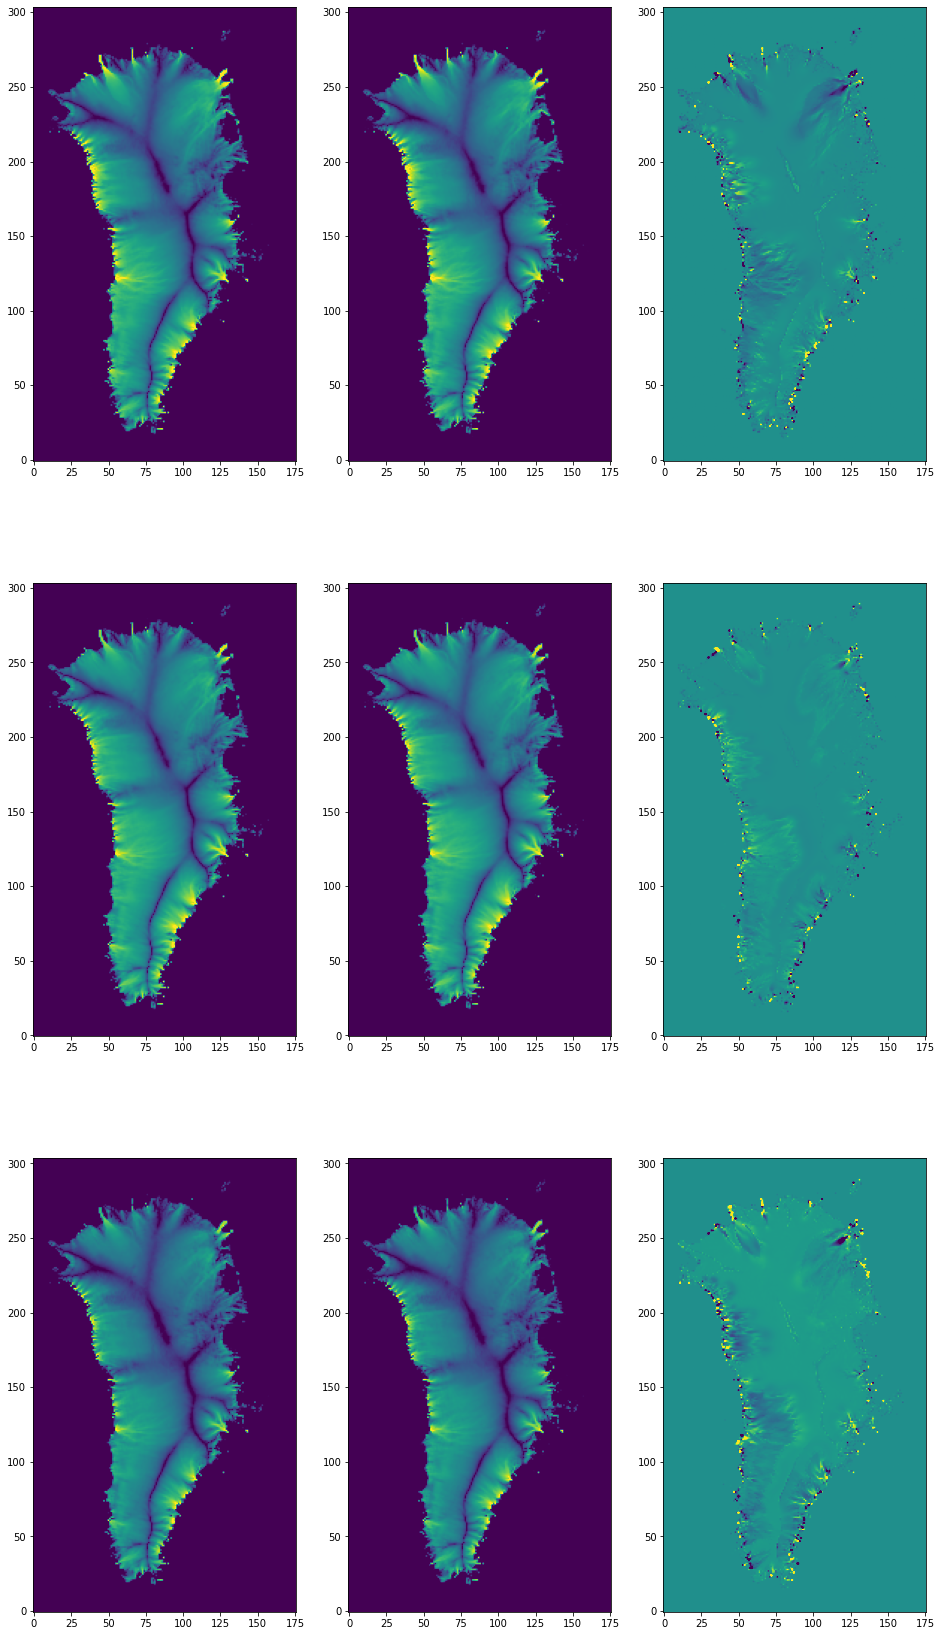

In [24]:
import matplotlib.pyplot as plt
F_pred = e(X,add_mean=True)
F_orig = F
fig,axs = plt.subplots(nrows=3,ncols=3)
fig.set_size_inches(16,30)
inds = np.random.randint(0,m,3)
axs[0,0].imshow(F_orig[inds[0],:].detach().cpu().numpy().reshape((ny,nx)),origin='lower',vmin=0,vmax=3)
axs[0,1].imshow(F_pred[inds[0],:].detach().cpu().numpy().reshape((ny,nx)),origin='lower',vmin=0,vmax=3)
axs[0,2].imshow((F_pred[inds[0],:].detach().cpu().numpy() - F_orig[inds[0],:].detach().cpu().numpy()).reshape((ny,nx)),origin='lower',vmin=-0.1,vmax=0.1)
axs[1,0].imshow(F_orig[inds[1],:].detach().cpu().numpy().reshape((ny,nx)),origin='lower',vmin=0,vmax=3)
axs[1,1].imshow(F_pred[inds[1],:].detach().cpu().numpy().reshape((ny,nx)),origin='lower',vmin=0,vmax=3)
axs[1,2].imshow((F_pred[inds[1],:].detach().cpu().numpy() - F_orig[inds[1],:].detach().cpu().numpy()).reshape((ny,nx)),origin='lower',vmin=-0.1,vmax=0.1)
axs[2,0].imshow(F_orig[inds[2],:].detach().cpu().numpy().reshape((ny,nx)),origin='lower',vmin=0,vmax=3)
axs[2,1].imshow(F_pred[inds[2],:].detach().cpu().numpy().reshape((ny,nx)),origin='lower',vmin=0,vmax=3)
axs[2,2].imshow((F_pred[inds[2],:].detach().cpu().numpy() - F_orig[inds[2],:].detach().cpu().numpy()).reshape((ny,nx)),origin='lower',vmin=-0.1,vmax=0.1)

from sklearn.metrics import mean_squared_error
for idx in range(3):
    rmsd = np.sqrt(mean_squared_error(10**F_pred[inds[idx], :].detach().cpu().numpy(), 10**F_orig[inds[0], :].detach().cpu().numpy()))
    print(rmsd)

In [23]:
plt.imshow(e.V_hat.weight.detach().cpu().numpy()[:,19].reshape(ny,nx),origin='lower',vmin=-0.5,vmax=0.5)
plt.colorbar()

AttributeError: 'Parameter' object has no attribute 'weight'

In [ ]:
nn.Linear?

## Part 2 - MCMC over the ensemble
Now that a number of neural network surrogates have been trained on random subsets of high-fidelity model runs, we will perform Markov Chain Monte Carlo sampling over each of these surrogates.  The correct parameter distribution for the high-fidelity model will be approximated by concatenating the Markov Chains over all of the surrogates.

In [24]:
import pickle
import numpy as np
import torch


Read in the models trained above.

In [25]:
models = []
n_models = 5 #To reproduce the paper, this should be 50

for i in range(n_models):
    state_dict = torch.load('emulator_ensemble_doug/emulator_{0:03d}.h5'.format(i))
    e = Emulator(state_dict['l_1.weight'].shape[1],state_dict['V_hat'].shape[1],n_hidden_1,n_hidden_2,n_hidden_3,n_hidden_4,state_dict['V_hat'],state_dict['F_mean'])
    e.load_state_dict(state_dict)
    e.to(device)
    e.eval()
    models.append(e)

Read in some relevant training data and ancillary values.  Convert observed velocities to speeds.

In [26]:
#u_obs = utilities.VData('./data/u_observed.vtu')
#v_obs = utilities.VData('./data/v_observed.vtu')
#H_obs = utilities.VData('./data/H_observed.vtu')

#H = torch.tensor(H_obs.u)
#H = H.to(torch.float32).to(device)

U_obs = torch.tensor(np.nan_to_num(o_speed.ravel()))#((np.sqrt(u_obs.u**2 + v_obs.u**2))))
U_obs = U_obs.to(torch.float32).to(device)

Define the likelihood model, which requires a parameterization of observational uncertainty.

In [27]:
from scipy.spatial.distance import pdist, squareform
#D = torch.tensor(squareform(pdist(u_obs.x)),dtype=torch.float32,device=device)

sigma2 = 10**2
#sigma_flow2 = 10**2
#alpha_cov = 1

l_model = 1e4#4*torch.sqrt(H.unsqueeze(1) @ H.unsqueeze(0))
#Sigma_obs = sigma2*torch.eye(U_obs.shape[0]*U_obs.shape[1],device=device)
#Sigma_flow = sigma_flow2*(1 + D**2/(2*alpha_cov*l_model**2))**-alpha_cov
#Sigma = Sigma_obs# + Sigma_flow

Construct the precision matrix (the inverse of equation 50)

In [28]:
rho = 1./(1e4**2)
point_area = 81e6
K = point_area*rho

Tau = K * 1./sigma2 * K

In [29]:
sigma_hat = np.sqrt(sigma2/K**2)

Construct the Beta prior distribution.  

In [30]:
from scipy.stats import beta
alpha_b = 3.0
beta_b = 3.0

X_min = X.cpu().numpy().min(axis=0)-1e-3
X_max = X.cpu().numpy().max(axis=0)+1e-3

X_prior = beta.rvs(alpha_b,beta_b,size=(10000,X.shape[1]))*(X_max - X_min) + X_min

X_min = torch.tensor(X_min,dtype=torch.float32,device=device)
X_max = torch.tensor(X_max,dtype=torch.float32,device=device)

In [109]:
X

tensor([[-0.9484, -1.3555,  0.0060,  ...,  1.4312, -1.5577,  1.3844],
        [ 0.0225, -1.3555,  0.0060,  ...,  1.4312, -1.5577,  1.3844],
        [-0.9484, -1.4498,  0.0060,  ...,  1.4312, -1.5577,  1.3844],
        ...,
        [-0.1107,  0.3365,  0.1421,  ...,  0.8093,  0.0184, -1.4830],
        [-0.1107,  0.3365,  0.1421,  ...,  0.8093, -1.1760, -0.2898],
        [ 0.8332,  0.5452,  0.9674,  ...,  1.3284,  0.0184, -0.2898]])

This function returns a value that is proportional to the negative log-posterior distribution (The summands of equation 53).  

In [79]:
alpha = 0.01
from scipy.special import gamma
nu = 1.
def V(X):
    U_pred = 10**m(X,add_mean=True)
    #print(U_pred.min())
    r = (U_pred - U_obs)
    X_bar = (X - X_min)/(X_max - X_min)

    #L1 = -0.5*Tau*r @ r
    #L1 = -(1 + r.shape[0])/2.*torch.log(1 + r@r*Tau)
    #L1 = torch.sum(-np.log(np.sqrt(np.pi*2)*sigma_hat) - 1./2.*(r/sigma_hat)**2)
    L1 = torch.sum(np.log(gamma((nu+1)/2.)) - np.log(gamma(nu/2.)) - np.log(np.sqrt(np.pi*nu)*sigma_hat) - (nu+1)/2.*torch.log(1 + 1./nu*(r/sigma_hat)**2))
    L2 = torch.sum((alpha_b-1)*torch.log(X_bar) + (beta_b-1)*torch.log(1-X_bar)) 

    #print(L1,L2)
    return -(alpha*L1 + L2)

In [34]:
m = models[2]
X0 = torch.tensor(X_prior.mean(axis=0),dtype=torch.float,device=device)
print(X0)

tensor([ 0.0056,  0.0301, -0.0760, -0.0079, -0.0044,  0.0113,  0.0405,  0.0087])


We use the Metropolis-adjusted Langevin Algorithm to sample from the posterior distribution, which benefits from the availability of gradient and Hessian information.  Here, we compute these quantities (and some helpful additional ones) using automatic differentiation in pytorch.

In [80]:
def get_log_like_gradient_and_hessian(V,X,eps=1e-2,compute_hessian=False):
    log_pi = V(X)
    if compute_hessian:
        g = torch.autograd.grad(log_pi,X,retain_graph=True,create_graph=True)[0]
        H = torch.stack([torch.autograd.grad(e,X,retain_graph=True)[0] for e in g])
        lamda,Q = torch.eig(H,eigenvectors=True)
        lamda_prime = torch.sqrt(lamda[:,0]**2 + eps)
        lamda_prime_inv = 1./torch.sqrt(lamda[:,0]**2 + eps)
        H = Q @ torch.diag(lamda_prime) @ Q.T
        Hinv = Q @ torch.diag(lamda_prime_inv) @ Q.T
        log_det_Hinv = torch.sum(torch.log(lamda_prime_inv))
        return log_pi,g,H,Hinv,log_det_Hinv
    else: 
        return log_pi

We initialize the sampler by first finding the Maximum A Posteriori parameter value, or MAP point.  We find the MAP point using gradient descent paired with a simple line search.

In [81]:
def find_MAP(X,n_iters=50,print_interval=10):
    print('***********************************************')
    print('***********************************************')
    print('Finding MAP point')
    print('***********************************************')
    print('***********************************************')
    # Line search distances
    alphas = np.logspace(-4,0,11)
    # Find MAP point
    for i in range(n_iters):
        log_pi,g,H,Hinv,log_det_Hinv = get_log_like_gradient_and_hessian(V,X,compute_hessian=True)
        p = Hinv @ -g
        alpha_index = np.nanargmin([get_log_like_gradient_and_hessian(V,X + alpha*p,compute_hessian=False).detach().cpu().numpy() for alpha in alphas])
        mu = X + alphas[alpha_index] * p 
        X.data = mu.data
        if i%print_interval==0:
            print('===============================================')
            print('iter: {0:d}, ln(P): {1:6.1f}, curr. m: {2:4.4f},{3:4.2f},{4:4.2f},{5:4.2f},{6:4.2f},{7:4.2f},{8:4.2f},{9:4.2f}'.format(i,log_pi,*X.data.cpu().numpy()))
            print('===============================================')
    return X

With a good initial guess for the sampler discovered, we now implement the MALA algorithm.  

In [82]:
def draw_sample(mu,cov,eps=1e-10):
    L = torch.cholesky(cov + eps*torch.eye(cov.shape[0],device=device))
    return mu + L @ torch.randn(L.shape[0],device=device)

def get_proposal_likelihood(Y,mu,inverse_cov,log_det_cov):
    return -0.5*log_det_cov - 0.5*(Y - mu) @ inverse_cov @ (Y-mu)

def MALA_step(X,h,local_data=None):
    if local_data is not None:
        pass  
    else:
        local_data = get_log_like_gradient_and_hessian(V,X,compute_hessian=True)
        
    log_pi,g,H,Hinv,log_det_Hinv = local_data
    
    X_ = draw_sample(X,2*h*Hinv).detach()
    X_.requires_grad=True
    
    log_pi_ = get_log_like_gradient_and_hessian(V,X_,compute_hessian=False)

    logq = get_proposal_likelihood(X_,X,H/(2*h),log_det_Hinv)
    logq_ = get_proposal_likelihood(X,X_,H/(2*h),log_det_Hinv)

    log_alpha = (-log_pi_ + logq_ + log_pi - logq)
    alpha = torch.exp(min(log_alpha,torch.tensor([0.],device=device)))
    u = torch.rand(1,device=device)
    if u <= alpha and log_alpha!=np.inf:
        X.data = X_.data
        local_data = get_log_like_gradient_and_hessian(V,X,compute_hessian=True)
        s = 1
    else:
        s = 0
    return X,local_data,s

def MALA(X,n_iters=10001,h=0.1,h_max=1.0,acc_target=0.25,k=0.01,beta=0.99,sample_path='./samples/',model_index=0,save_interval=1000,print_interval=50):
    print('***********************************************')
    print('***********************************************')
    print('Running Metropolis-Adjusted Langevin Algorithm for model index {0}'.format(model_index))
    print('***********************************************')
    print('***********************************************')
    local_data = None
    vars = []
    acc = acc_target
    for i in range(n_iters):
        X,local_data,s = MALA_step(X,h,local_data=local_data)
        vars.append(X.detach())
        acc = beta*acc + (1-beta)*s
        h = min(h*(1+k*np.sign(acc - acc_target)),h_max)
        if i%print_interval==0:
            print('===============================================')
            print('sample: {0:d}, acc. rate: {1:4.2f}, log(P): {2:6.1f}'.format(i,acc,local_data[0].item()))
            print('curr. m: {0:4.4f},{1:4.2f},{2:4.2f},{3:4.2f},{4:4.2f},{5:4.2f},{6:4.2f},{7:4.2f}'.format(*X.data.cpu().numpy()))
            print('===============================================')
          
        if i%save_interval==0:
            print('///////////////////////////////////////////////')
            print('Saving samples for model {0:03d}'.format(model_index))
            print('///////////////////////////////////////////////')
            X_posterior = torch.stack(vars).cpu().numpy()
            np.save(open(sample_path+'X_posterior_model_{0:03d}.npy'.format(model_index),'wb'),X_posterior)
    X_posterior = torch.stack(vars).cpu().numpy()
    return X_posterior       

In [40]:
m = models[0]
X_0 = torch.tensor(X_prior.mean(axis=0),requires_grad=True,dtype=torch.float,device=device)
X_0 = find_MAP(X_0,n_iters=50)

***********************************************
***********************************************
Finding MAP point
***********************************************
***********************************************
iter: 0, ln(P): 2193.6, curr. m: -0.5296,0.13,-0.13,0.11,-0.13,-0.07,-0.07,0.09
iter: 10, ln(P): 2171.6, curr. m: -0.3933,0.02,-0.70,0.39,0.19,0.16,-0.17,0.52
iter: 20, ln(P): 2171.6, curr. m: -0.3931,0.02,-0.70,0.39,0.19,0.16,-0.17,0.52
iter: 30, ln(P): 2171.6, curr. m: -0.3931,0.02,-0.70,0.39,0.19,0.16,-0.17,0.52
iter: 40, ln(P): 2171.6, curr. m: -0.3931,0.02,-0.70,0.39,0.19,0.16,-0.17,0.52


In [59]:
def V(m, X):
    U_pred = 10**m(X,add_mean=True)
    r = (U_pred - U_obs)
    X_bar = (X - X_min)/(X_max - X_min)


    L1 = torch.sum(np.log(gamma((nu+1)/2.)) - np.log(gamma(nu/2.)) - np.log(np.sqrt(np.pi*nu)*sigma_hat) - (nu+1)/2.*torch.log(1 + 1./nu*(r/sigma_hat)**2))
    L2 = torch.sum((alpha_b-1)*torch.log(X_bar) + (beta_b-1)*torch.log(1-X_bar)) 

    print(L1)
    return -(alpha*L1 + L2)

In [72]:
U_pred = 10**m(X,add_mean=True)
r = (U_pred - U_obs)
print(f"r: {r}\n nu: {nu}\n sigma_hat: {sigma_hat}")

torch.log(1 + 1./nu*(r/sigma_hat)**2)

r: tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
       grad_fn=<SubBackward0>)
 nu: 1.0
 sigma_hat: 12.345679012345679


tensor([[0.0065, 0.0065, 0.0065,  ..., 0.0065, 0.0065, 0.0065],
        [0.0065, 0.0065, 0.0065,  ..., 0.0065, 0.0065, 0.0065],
        [0.0065, 0.0065, 0.0065,  ..., 0.0065, 0.0065, 0.0065],
        ...,
        [0.0065, 0.0065, 0.0065,  ..., 0.0065, 0.0065, 0.0065],
        [0.0065, 0.0065, 0.0065,  ..., 0.0065, 0.0065, 0.0065],
        [0.0065, 0.0065, 0.0065,  ..., 0.0065, 0.0065, 0.0065]],
       grad_fn=<LogBackward>)

We now run the MAP/MALA procedure for each surrogate in the bootstrapped ensemble, and save the resulting posterior distributions.

In [84]:
torch.manual_seed(0)
np.random.seed(0)
for j,m in enumerate(models):
    X_0 = torch.tensor(X_prior.mean(axis=0),requires_grad=True,dtype=torch.float,device=device)
    X_0 = find_MAP(X_0,n_iters=50)
    # To reproduce the paper, n_iters should be 10^5
    X_posterior = MALA(X_0,n_iters=10000,model_index=j,sample_path="./posterior_samples_doug/", save_interval=1000,print_interval=100)

***********************************************
***********************************************
Finding MAP point
***********************************************
***********************************************
iter: 0, ln(P): 2193.6, curr. m: -0.5296,0.13,-0.13,0.11,-0.13,-0.07,-0.07,0.09
iter: 10, ln(P): 2171.6, curr. m: -0.3933,0.02,-0.70,0.39,0.19,0.16,-0.17,0.52
iter: 20, ln(P): 2171.6, curr. m: -0.3931,0.02,-0.70,0.39,0.19,0.16,-0.17,0.52
iter: 30, ln(P): 2171.6, curr. m: -0.3931,0.02,-0.70,0.39,0.19,0.16,-0.17,0.52
iter: 40, ln(P): 2171.6, curr. m: -0.3931,0.02,-0.70,0.39,0.19,0.16,-0.17,0.52
***********************************************
***********************************************
Running Metropolis-Adjusted Langevin Algorithm for model index 0
***********************************************
***********************************************
sample: 0, acc. rate: 0.25, log(P): 2171.6
curr. m: -0.3931,0.02,-0.70,0.39,0.19,0.16,-0.17,0.52
////////////////////////////////////////

sample: 3300, acc. rate: 0.25, log(P): 2176.4
curr. m: -0.4074,-0.34,-0.82,-0.10,-1.17,1.17,-0.09,-0.79
sample: 3400, acc. rate: 0.25, log(P): 2173.6
curr. m: -0.3578,-0.10,-0.73,0.06,-0.65,1.13,-0.03,-0.60
sample: 3500, acc. rate: 0.21, log(P): 2174.2
curr. m: -0.8776,-0.53,-0.40,0.47,-0.38,0.09,-0.12,0.61
sample: 3600, acc. rate: 0.25, log(P): 2174.2
curr. m: -0.3256,0.14,-0.75,-0.00,-0.48,1.13,-0.41,-0.19
sample: 3700, acc. rate: 0.28, log(P): 2173.3
curr. m: -0.5271,0.06,-0.77,0.55,0.57,-0.51,-0.10,0.99
sample: 3800, acc. rate: 0.17, log(P): 2175.1
curr. m: -0.6451,-1.15,-0.97,0.28,-0.79,-0.02,-0.44,0.20
sample: 3900, acc. rate: 0.25, log(P): 2174.3
curr. m: -0.5523,-0.16,-0.89,0.31,0.60,0.47,0.16,0.80
sample: 4000, acc. rate: 0.21, log(P): 2175.3
curr. m: -0.3397,-0.40,-1.06,0.67,-0.18,-0.48,-0.82,1.12
///////////////////////////////////////////////
Saving samples for model 000
///////////////////////////////////////////////
sample: 4100, acc. rate: 0.27, log(P): 2176.0
curr. m: -

sample: 7200, acc. rate: 0.17, log(P): 2176.5
curr. m: -0.6930,1.03,0.06,0.64,0.66,-0.10,-0.44,0.87
sample: 7300, acc. rate: 0.22, log(P): 2177.3
curr. m: -0.6586,0.90,-0.28,0.31,1.43,0.73,0.13,1.18
sample: 7400, acc. rate: 0.32, log(P): 2176.0
curr. m: -0.1783,0.39,-0.82,0.38,0.62,-0.10,-0.08,0.79
sample: 7500, acc. rate: 0.23, log(P): 2175.8
curr. m: -0.6963,-0.02,-0.52,0.18,0.65,-0.08,-0.31,1.06
sample: 7600, acc. rate: 0.26, log(P): 2173.8
curr. m: -0.4089,-0.49,-0.90,0.11,0.14,0.67,-0.79,0.49
sample: 7700, acc. rate: 0.25, log(P): 2173.7
curr. m: -0.3586,-0.02,-0.60,0.07,-0.02,0.42,-0.04,-0.70
sample: 7800, acc. rate: 0.21, log(P): 2176.3
curr. m: -0.8709,0.32,-0.47,0.37,-0.09,-0.78,-0.42,0.67
sample: 7900, acc. rate: 0.26, log(P): 2174.9
curr. m: -0.4572,0.45,-0.59,1.00,0.30,-0.87,0.41,0.46
sample: 8000, acc. rate: 0.28, log(P): 2173.3
curr. m: -0.5852,0.13,-0.60,0.22,0.35,0.15,0.05,0.36
///////////////////////////////////////////////
Saving samples for model 000
////////////////

sample: 500, acc. rate: 0.27, log(P): 2173.5
curr. m: -0.5081,0.09,-0.84,0.27,-0.58,0.45,-1.13,0.22
sample: 600, acc. rate: 0.28, log(P): 2176.6
curr. m: -0.3788,-0.85,-0.95,0.75,-1.39,0.30,-0.30,-0.02
sample: 700, acc. rate: 0.25, log(P): 2174.4
curr. m: -0.4291,0.40,-0.98,0.84,1.07,0.20,0.12,1.23
sample: 800, acc. rate: 0.28, log(P): 2184.4
curr. m: -0.4248,0.16,-0.79,0.99,-1.13,0.82,-1.64,1.67
sample: 900, acc. rate: 0.22, log(P): 2175.3
curr. m: -0.6963,0.27,-0.97,0.22,-0.33,1.09,-0.93,0.41
sample: 1000, acc. rate: 0.22, log(P): 2175.2
curr. m: -0.2500,0.84,-0.67,0.67,-0.67,0.24,-0.72,0.19
///////////////////////////////////////////////
Saving samples for model 001
///////////////////////////////////////////////
sample: 1100, acc. rate: 0.25, log(P): 2176.7
curr. m: -0.6730,0.43,-0.72,0.89,1.22,-0.10,0.22,1.49
sample: 1200, acc. rate: 0.25, log(P): 2173.4
curr. m: -0.7494,0.06,-0.43,0.33,-0.40,0.90,-0.56,0.05
sample: 1300, acc. rate: 0.26, log(P): 2175.2
curr. m: -0.3407,0.32,-0.61

sample: 4500, acc. rate: 0.29, log(P): 2177.0
curr. m: -0.6140,0.30,-0.30,0.14,1.36,0.53,-1.00,1.06
sample: 4600, acc. rate: 0.23, log(P): 2176.6
curr. m: -0.5515,0.12,-0.57,-0.01,1.59,0.55,-0.53,-0.32
sample: 4700, acc. rate: 0.30, log(P): 2177.3
curr. m: -0.7583,0.42,-0.59,0.01,-0.53,1.46,-0.99,-0.20
sample: 4800, acc. rate: 0.13, log(P): 2174.2
curr. m: -0.6969,0.15,-0.57,0.36,0.58,1.00,-0.51,0.31
sample: 4900, acc. rate: 0.18, log(P): 2173.2
curr. m: -0.3340,0.43,-1.00,0.80,-0.01,0.56,-0.30,0.82
sample: 5000, acc. rate: 0.24, log(P): 2173.0
curr. m: -0.6835,0.07,-0.75,0.52,-0.58,0.36,-0.96,0.60
///////////////////////////////////////////////
Saving samples for model 001
///////////////////////////////////////////////
sample: 5100, acc. rate: 0.27, log(P): 2177.2
curr. m: -0.4292,-0.29,-0.60,0.52,1.21,-0.80,0.61,0.38
sample: 5200, acc. rate: 0.23, log(P): 2176.8
curr. m: -0.6705,0.82,-0.32,0.82,-0.00,0.57,-0.35,0.96
sample: 5300, acc. rate: 0.18, log(P): 2178.3
curr. m: -0.2857,-0.1

sample: 8400, acc. rate: 0.23, log(P): 2172.8
curr. m: -0.5872,-0.14,-0.90,0.70,-0.72,-0.29,-0.62,0.53
sample: 8500, acc. rate: 0.35, log(P): 2177.5
curr. m: -0.5646,0.22,-0.66,0.74,-1.56,0.99,-1.34,0.43
sample: 8600, acc. rate: 0.31, log(P): 2175.5
curr. m: -0.3177,0.24,-0.69,0.59,-1.51,-0.11,-1.15,0.04
sample: 8700, acc. rate: 0.21, log(P): 2175.9
curr. m: -0.3088,0.20,-0.81,0.94,-1.13,0.33,-0.27,0.45
sample: 8800, acc. rate: 0.20, log(P): 2175.3
curr. m: -0.7062,0.16,-0.51,0.21,1.14,0.16,-0.05,0.74
sample: 8900, acc. rate: 0.25, log(P): 2172.7
curr. m: -0.6294,-0.18,-0.65,0.69,-0.37,1.00,-0.20,0.87
sample: 9000, acc. rate: 0.25, log(P): 2179.0
curr. m: -0.3922,0.38,-1.35,0.68,1.01,1.07,-0.02,1.30
///////////////////////////////////////////////
Saving samples for model 001
///////////////////////////////////////////////
sample: 9100, acc. rate: 0.24, log(P): 2178.3
curr. m: -0.5192,-0.09,-0.63,0.94,-0.29,0.93,-0.70,1.69
sample: 9200, acc. rate: 0.22, log(P): 2174.4
curr. m: -0.4005,0

sample: 1700, acc. rate: 0.27, log(P): 2184.5
curr. m: -0.3497,-0.23,-0.19,1.48,-0.47,-1.66,0.03,1.05
sample: 1800, acc. rate: 0.24, log(P): 2174.7
curr. m: -0.6025,-0.86,-0.90,0.92,-0.87,-0.27,-0.58,0.71
sample: 1900, acc. rate: 0.25, log(P): 2180.0
curr. m: -0.4720,0.21,-0.50,1.50,0.94,-1.30,0.72,1.09
sample: 2000, acc. rate: 0.31, log(P): 2176.0
curr. m: -0.7553,-0.11,-0.81,0.55,-0.46,-0.15,0.32,-0.10
///////////////////////////////////////////////
Saving samples for model 002
///////////////////////////////////////////////
sample: 2100, acc. rate: 0.19, log(P): 2173.3
curr. m: -0.4156,-0.14,-0.78,0.62,0.11,-0.33,-0.02,0.54
sample: 2200, acc. rate: 0.23, log(P): 2176.5
curr. m: -0.4115,0.40,-0.67,0.57,-1.34,0.20,-1.06,0.39
sample: 2300, acc. rate: 0.31, log(P): 2175.1
curr. m: -0.4454,-0.47,-0.55,0.75,-0.86,-0.55,-0.80,0.42
sample: 2400, acc. rate: 0.20, log(P): 2175.5
curr. m: -0.6033,0.02,-0.57,0.45,0.61,0.28,0.46,0.55
sample: 2500, acc. rate: 0.28, log(P): 2176.8
curr. m: -0.7536

sample: 5600, acc. rate: 0.32, log(P): 2175.4
curr. m: -0.4254,-0.15,-0.86,0.45,0.15,1.53,0.03,0.33
sample: 5700, acc. rate: 0.27, log(P): 2174.9
curr. m: -0.7051,-0.25,-0.84,0.73,-1.16,-0.78,-0.43,0.11
sample: 5800, acc. rate: 0.22, log(P): 2175.5
curr. m: -0.6157,-0.79,-0.82,0.12,-0.35,-0.46,0.06,-0.52
sample: 5900, acc. rate: 0.25, log(P): 2172.7
curr. m: -0.4749,-0.32,-0.91,0.56,0.06,0.94,0.17,0.08
sample: 6000, acc. rate: 0.29, log(P): 2175.1
curr. m: -0.4418,-0.46,-0.93,1.09,-1.16,1.22,-0.47,1.07
///////////////////////////////////////////////
Saving samples for model 002
///////////////////////////////////////////////
sample: 6100, acc. rate: 0.17, log(P): 2173.9
curr. m: -0.5792,-1.10,-1.03,0.77,-0.48,0.46,-0.05,0.64
sample: 6200, acc. rate: 0.23, log(P): 2172.6
curr. m: -0.4887,-0.49,-0.92,0.96,-1.02,0.50,-0.51,0.90
sample: 6300, acc. rate: 0.25, log(P): 2175.1
curr. m: -0.6397,-0.14,-0.71,0.95,-0.34,-0.78,-0.57,1.19
sample: 6400, acc. rate: 0.23, log(P): 2182.7
curr. m: -0.06

sample: 9500, acc. rate: 0.29, log(P): 2175.3
curr. m: -0.3896,-0.46,-0.58,0.26,-0.71,0.57,-0.24,-0.42
sample: 9600, acc. rate: 0.29, log(P): 2179.0
curr. m: -0.3872,-0.30,-1.26,0.78,-0.75,1.66,-0.64,0.81
sample: 9700, acc. rate: 0.21, log(P): 2177.3
curr. m: -0.4429,0.49,-0.23,1.12,-0.37,-0.38,-0.15,1.27
sample: 9800, acc. rate: 0.20, log(P): 2177.2
curr. m: -0.6525,-0.21,-0.77,-0.02,-0.36,1.53,-0.96,0.05
sample: 9900, acc. rate: 0.26, log(P): 2178.7
curr. m: -0.5329,0.26,-0.51,1.16,-0.22,0.11,-0.84,1.66
***********************************************
***********************************************
Finding MAP point
***********************************************
***********************************************
iter: 0, ln(P): 2189.4, curr. m: 0.0364,0.18,-0.17,0.05,0.22,-0.01,0.11,0.01
iter: 10, ln(P): 2171.6, curr. m: -0.3889,0.00,-0.48,0.51,-0.05,-0.06,0.14,0.12
iter: 20, ln(P): 2171.4, curr. m: -0.3944,0.07,-0.50,0.51,0.02,-0.01,0.12,0.17
iter: 30, ln(P): 2171.4, curr. m: -0.3944,0

sample: 2800, acc. rate: 0.29, log(P): 2177.2
curr. m: -0.6573,0.14,-0.75,0.88,0.54,1.01,0.70,1.27
sample: 2900, acc. rate: 0.28, log(P): 2174.6
curr. m: -0.4295,-0.30,-0.33,0.24,0.63,-0.28,0.21,0.03
sample: 3000, acc. rate: 0.23, log(P): 2181.9
curr. m: -0.2371,0.85,-0.51,0.38,-0.23,-1.37,-0.46,0.19
///////////////////////////////////////////////
Saving samples for model 003
///////////////////////////////////////////////
sample: 3100, acc. rate: 0.24, log(P): 2174.5
curr. m: -0.2724,0.60,-0.75,1.05,-0.00,-0.30,-0.18,1.06
sample: 3200, acc. rate: 0.21, log(P): 2176.7
curr. m: -0.3286,0.40,-0.36,0.50,-0.62,-0.75,-1.03,0.38
sample: 3300, acc. rate: 0.37, log(P): 2181.2
curr. m: -0.7688,0.86,-0.16,0.19,-0.06,-0.19,-1.52,0.78
sample: 3400, acc. rate: 0.28, log(P): 2183.8
curr. m: -0.8849,-1.46,-0.96,0.33,-1.51,-0.99,-0.52,0.21
sample: 3500, acc. rate: 0.18, log(P): 2174.6
curr. m: -0.5467,-0.45,-0.42,0.09,-0.33,1.03,-0.35,0.06
sample: 3600, acc. rate: 0.25, log(P): 2175.7
curr. m: -0.6147

sample: 6700, acc. rate: 0.23, log(P): 2175.7
curr. m: -0.3354,0.09,-0.66,0.53,0.06,-1.35,0.12,-0.02
sample: 6800, acc. rate: 0.26, log(P): 2177.0
curr. m: -0.6330,-0.82,-0.76,0.34,1.02,0.04,1.07,-0.10
sample: 6900, acc. rate: 0.32, log(P): 2178.8
curr. m: -0.3423,0.55,-1.08,1.19,0.70,0.18,0.49,1.62
sample: 7000, acc. rate: 0.25, log(P): 2175.7
curr. m: -0.4476,-1.01,-0.76,0.89,-0.73,-0.15,-0.57,0.63
///////////////////////////////////////////////
Saving samples for model 003
///////////////////////////////////////////////
sample: 7100, acc. rate: 0.16, log(P): 2179.6
curr. m: -0.6484,-0.37,-0.95,0.62,-0.97,1.41,-1.08,0.20
sample: 7200, acc. rate: 0.28, log(P): 2182.1
curr. m: -0.0621,0.99,-0.82,-0.01,-0.64,1.44,-1.27,-0.51
sample: 7300, acc. rate: 0.34, log(P): 2176.0
curr. m: -0.3164,0.07,-0.44,0.69,-0.56,1.31,0.11,0.26
sample: 7400, acc. rate: 0.19, log(P): 2174.5
curr. m: -0.4658,0.44,-0.33,0.19,0.43,-0.40,0.12,-0.46
sample: 7500, acc. rate: 0.21, log(P): 2176.3
curr. m: -0.3057,0.

sample: 100, acc. rate: 0.30, log(P): 2177.2
curr. m: -0.2928,0.05,-0.44,0.97,-1.22,-0.89,0.16,-0.18
sample: 200, acc. rate: 0.23, log(P): 2175.9
curr. m: -0.3654,0.22,-0.34,0.64,-0.04,1.24,0.17,0.08
sample: 300, acc. rate: 0.28, log(P): 2178.7
curr. m: -0.3154,0.31,-0.49,1.15,-1.27,-1.29,-0.52,0.34
sample: 400, acc. rate: 0.24, log(P): 2176.1
curr. m: -0.5045,-0.67,-0.73,0.87,-0.52,1.41,0.02,0.48
sample: 500, acc. rate: 0.26, log(P): 2175.4
curr. m: -0.5471,0.56,-0.85,0.59,-0.75,1.07,-0.41,0.27
sample: 600, acc. rate: 0.23, log(P): 2176.2
curr. m: -0.3244,-0.01,-1.10,0.92,-1.00,-1.06,-0.56,0.20
sample: 700, acc. rate: 0.23, log(P): 2175.7
curr. m: -0.2371,-0.30,-1.01,0.84,-1.35,0.39,-0.34,-0.00
sample: 800, acc. rate: 0.26, log(P): 2175.0
curr. m: -0.4687,0.71,-0.60,0.26,0.55,-0.43,-1.00,0.60
sample: 900, acc. rate: 0.24, log(P): 2174.6
curr. m: -0.7644,-0.75,-0.82,0.75,0.58,-0.48,0.75,0.46
sample: 1000, acc. rate: 0.31, log(P): 2177.6
curr. m: -0.1918,0.39,-0.95,0.82,-0.35,-0.99,0.06

sample: 4100, acc. rate: 0.29, log(P): 2181.4
curr. m: -0.5361,-0.32,-0.59,0.16,-1.11,1.71,-0.96,-0.20
sample: 4200, acc. rate: 0.21, log(P): 2178.6
curr. m: -0.3526,0.01,-0.13,0.25,-0.07,1.55,-0.96,0.24
sample: 4300, acc. rate: 0.24, log(P): 2184.7
curr. m: -0.5010,-0.74,-0.63,1.33,-1.71,0.56,-0.53,1.29
sample: 4400, acc. rate: 0.34, log(P): 2178.8
curr. m: -0.5526,-0.15,-0.90,1.06,-0.94,-1.54,-0.76,1.10
sample: 4500, acc. rate: 0.24, log(P): 2174.5
curr. m: -0.4020,0.06,-0.45,0.34,0.07,-0.44,0.07,-0.15
sample: 4600, acc. rate: 0.17, log(P): 2173.9
curr. m: -0.4487,0.01,-0.71,0.88,-0.76,-0.87,-0.47,0.63
sample: 4700, acc. rate: 0.23, log(P): 2178.6
curr. m: -0.4606,0.19,-0.68,0.05,1.60,-0.43,0.37,0.18
sample: 4800, acc. rate: 0.32, log(P): 2179.5
curr. m: -0.3093,-0.18,-1.28,0.41,0.27,-0.80,-0.84,0.69
sample: 4900, acc. rate: 0.22, log(P): 2179.1
curr. m: -0.5340,-0.31,-0.34,0.80,-0.82,-1.59,-0.44,0.58
sample: 5000, acc. rate: 0.23, log(P): 2175.7
curr. m: -0.4965,0.38,-0.66,1.09,0.03

sample: 8100, acc. rate: 0.26, log(P): 2180.1
curr. m: -0.5961,0.30,-0.80,1.43,-1.42,1.37,-0.27,0.69
sample: 8200, acc. rate: 0.26, log(P): 2180.6
curr. m: -0.5984,-0.70,-1.13,1.51,-1.52,0.74,-0.87,1.39
sample: 8300, acc. rate: 0.19, log(P): 2177.6
curr. m: -0.4258,-0.23,-0.70,1.10,-0.13,-1.15,0.77,0.42
sample: 8400, acc. rate: 0.36, log(P): 2178.8
curr. m: -0.2296,-0.12,-0.83,0.28,-1.57,1.45,-1.03,-0.16
sample: 8500, acc. rate: 0.24, log(P): 2179.3
curr. m: -0.3981,0.18,-0.43,1.29,-1.09,1.36,-0.05,0.87
sample: 8600, acc. rate: 0.28, log(P): 2176.4
curr. m: -0.6342,-0.48,-0.67,0.96,-0.95,-1.27,-0.22,0.82
sample: 8700, acc. rate: 0.23, log(P): 2177.1
curr. m: -0.4477,0.88,-0.34,0.06,-0.03,1.24,-0.70,-0.15
sample: 8800, acc. rate: 0.28, log(P): 2176.8
curr. m: -0.5318,0.57,-0.28,0.65,0.39,0.39,0.57,0.11
sample: 8900, acc. rate: 0.23, log(P): 2173.1
curr. m: -0.5025,-0.24,-0.56,0.64,0.15,-0.45,0.08,0.66
sample: 9000, acc. rate: 0.25, log(P): 2176.2
curr. m: -0.4480,-0.11,-0.65,1.16,0.75,-

In [75]:
models

[Emulator(
   (l_1): Linear(in_features=8, out_features=128, bias=True)
   (norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
   (dropout_1): Dropout(p=0.0, inplace=False)
   (l_2): Linear(in_features=128, out_features=128, bias=True)
   (norm_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
   (dropout_2): Dropout(p=0.5, inplace=False)
   (l_3): Linear(in_features=128, out_features=128, bias=True)
   (norm_3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
   (dropout_3): Dropout(p=0.5, inplace=False)
   (l_4): Linear(in_features=128, out_features=128, bias=True)
   (norm_4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
   (dropout_4): Dropout(p=0.5, inplace=False)
   (l_5): Linear(in_features=128, out_features=93, bias=True)
 ),
 Emulator(
   (l_1): Linear(in_features=8, out_features=128, bias=True)
   (norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
   (dropout_1): Dropout(p=0.0, inplace=False)
   (l_2): Linear(in_features=128, ou

FileNotFoundError: [Errno 2] No such file or directory: './samples/X_posterior_model_001.npy'

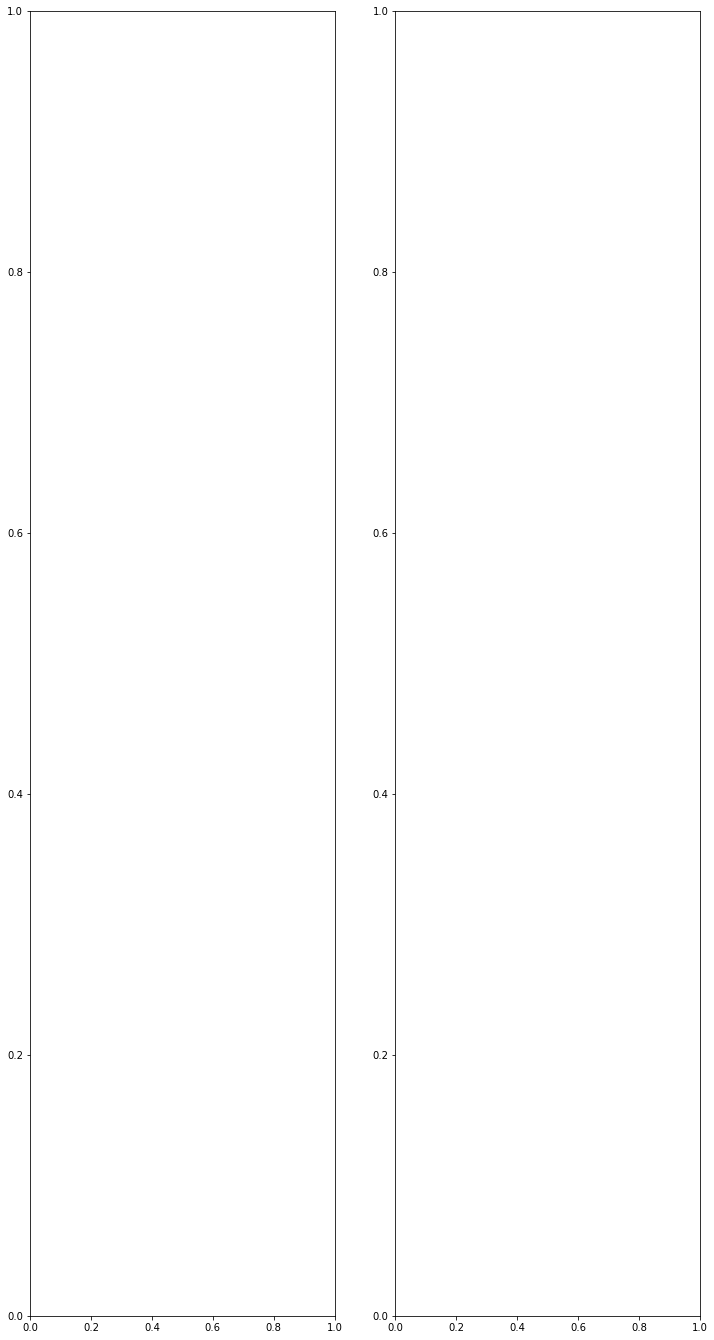

In [77]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(12,24)
model_index = 1
X_posterior = np.load(open('./samples/X_posterior_model_{0:03d}.npy'.format(model_index),'rb'))
axs[0].imshow((m(torch.tensor(X_posterior[1000],device=device),add_mean=True) - m(torch.tensor(X_posterior[0],device=device),add_mean=True)).detach().cpu().numpy().reshape((ny,nx)),origin='lower',vmin=-0.1,vmax=0.1)
axs[1].imshow(np.log10(U_obs.detach().cpu().numpy().reshape((ny,nx))+1e-3),origin='lower',vmin=0,vmax=3)

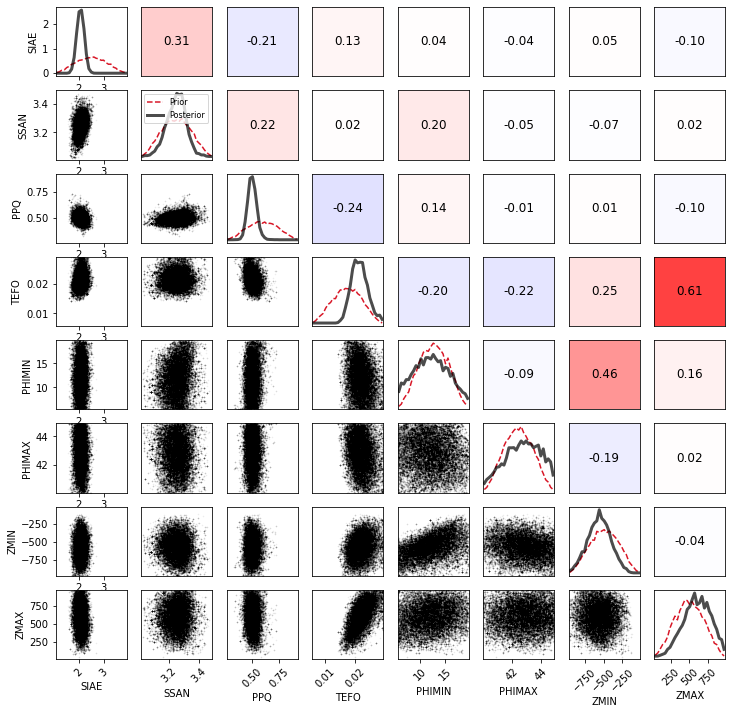

In [85]:
from matplotlib.ticker import NullFormatter,ScalarFormatter
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

#X_posterior = X_posterior*X_s.cpu().numpy() + X_m.cpu().numpy()
X_prior = X_prior*X_s.cpu().numpy() + X_m.cpu().numpy()

X_hat = X_prior

fig,axs = plt.subplots(nrows=8,ncols=8,figsize=(12,12))
X_list = []

for model_index in range(n_models):
    X_list.append(np.load(open('./posterior_samples_doug/X_posterior_model_{0:03d}.npy'.format(model_index),'rb')))
    
X_posterior = np.vstack(X_list)    
X_posterior = X_posterior*X_s.cpu().numpy() + X_m.cpu().numpy()

C_0 = np.corrcoef((X_posterior - X_posterior.mean(axis=0)).T)
Cn_0 = (np.sign(C_0)*C_0**2 + 1)/2.

color_post_0 = '#00B25F'
color_post_1 = '#132DD6'
color_prior = '#D81727'
color_ensemble = '#BA9B00'
color_other = '#20484E0'


for i in range(8):
    for j in range(8):
        if i>j:
            
            axs[i,j].scatter(X_posterior[:,j],X_posterior[:,i],c='k',s=0.5,alpha=0.05,label='Posterior',rasterized=True)
            min_val = min(X_hat[:,i].min(),X_posterior[:,i].min())
            max_val = max(X_hat[:,i].max(),X_posterior[:,i].max())
            bins_y = np.linspace(min_val,max_val,30)

            min_val = min(X_hat[:,j].min(),X_posterior[:,j].min())
            max_val = max(X_hat[:,j].max(),X_posterior[:,j].max())
            bins_x = np.linspace(min_val,max_val,30)
            
            #v = st.gaussian_kde(X_posterior[:,[j,i]].T)
            #bx = 0.5*(bins_x[1:] + bins_x[:-1])
            #by = 0.5*(bins_y[1:] + bins_y[:-1])
            #Bx,By = np.meshgrid(bx,by)
            
            #axs[i,j].contour(10**Bx,10**By,v(np.vstack((Bx.ravel(),By.ravel()))).reshape(Bx.shape),7,alpha=0.7,colors='black')

            axs[i,j].set_xlim(X_hat[:,j].min(),X_hat[:,j].max())
            axs[i,j].set_ylim(X_hat[:,i].min(),X_hat[:,i].max())

            #axs[i,j].set_xscale('log')
            #axs[i,j].set_yscale('log')

        elif i<j:
            patch_upper = Polygon(np.array([[0.,0.],[0.,1.],[1.,1.],[1.,0.]]),facecolor=plt.cm.seismic(Cn_0[i,j]))
            #patch_lower = Polygon(np.array([[0.,0.],[1.,0.],[1.,1.]]),facecolor=plt.cm.seismic(Cn_1[i,j]))
            axs[i,j].add_patch(patch_upper)
            #axs[i,j].add_patch(patch_lower)
            if C_0[i,j]>-0.5:
                color = 'black'
            else:
                color = 'white'
            axs[i,j].text(0.5,0.5,'{0:.2f}'.format(C_0[i,j]),fontsize=12,horizontalalignment='center',verticalalignment='center',transform=axs[i,j].transAxes,color=color)
            #if C_1[i,j]>-0.5:
            #    color = 'black'
            #else:
            #    color = 'white'

            #axs[i,j].text(0.75,0.25,'{0:.2f}'.format(C_1[i,j]),fontsize=12,horizontalalignment='center',verticalalignment='center',transform=axs[i,j].transAxes,color=color)

        elif i==j:
            min_val = min(X_hat[:,i].min(),X_posterior[:,i].min())
            max_val = max(X_hat[:,i].max(),X_posterior[:,i].max())
            bins = np.linspace(min_val,max_val,30)
            #X_hat_hist,b = np.histogram(X_hat[:,i],bins,density=True)
            X_prior_hist,b = np.histogram(X_prior[:,i],bins,density=True)
            X_posterior_hist = np.histogram(X_posterior[:,i],bins,density=True)[0]
            b = 0.5*(b[1:] + b[:-1])
            lw = 3.0
            axs[i,j].plot(b,X_prior_hist,color=color_prior,linewidth=0.5*lw,label='Prior',linestyle='dashed')
            
            axs[i,j].plot(b,X_posterior_hist,color='black',linewidth=lw,linestyle='solid',label='Posterior',alpha=0.7)

            #for X_ind in X_stack:
            #    X_hist,_ = np.histogram(X_ind[:,i],bins,density=False)
            #    X_hist=X_hist/len(X_posterior)
            #    X_hist=X_hist/(bins[1]-bins[0])
            #    axs[i,j].plot(10**b,X_hist,'b-',alpha=0.2,lw=0.5)

            if i==1:
                axs[i,j].legend(fontsize=8)
            axs[i,j].set_xlim(min_val,max_val)
            #axs[i,j].set_xscale('log')

        else:
            axs[i,j].remove()

keys=samples.keys()

for i,ax in enumerate(axs[:,0]):
    ax.set_ylabel(keys[i])

for j,ax in enumerate(axs[-1,:]):
    ax.set_xlabel(keys[j])
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)
    if j>0:
        ax.tick_params(axis='y',which='both',length=0)
        ax.yaxis.set_minor_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())

for ax in axs[:-1,1:].ravel():
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.tick_params(axis='both',which='both',length=0)

#fig.savefig('speed_emulator_posterior.pdf')

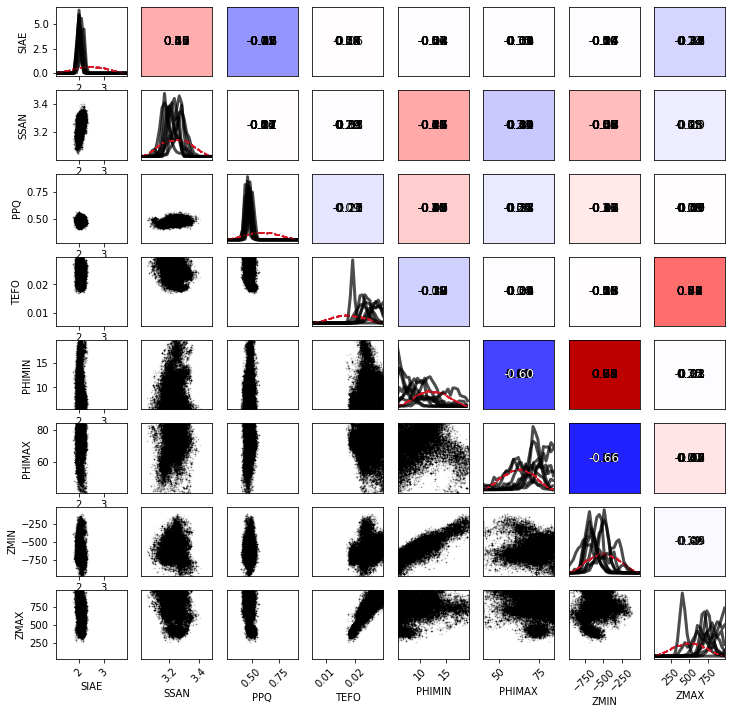

In [110]:
from matplotlib.ticker import NullFormatter,ScalarFormatter
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

#X_posterior = X_posterior*X_s.cpu().numpy() + X_m.cpu().numpy()
#X_prior = X_prior*X_s.cpu().numpy() + X_m.cpu().numpy()

X_hat = X_prior

fig,axs = plt.subplots(nrows=8,ncols=8,figsize=(12,12))
color_post_0 = '#00B25F'
color_post_1 = '#132DD6'
color_prior = '#D81727'
color_ensemble = '#BA9B00'
color_other = '#20484E0'


for model_index in range(9):
    X_posterior = np.load(open('./samples/X_posterior_model_{0:03d}.npy'.format(model_index),'rb'))
    X_posterior = X_posterior*X_s.cpu().numpy() + X_m.cpu().numpy()
    
    
    C_0 = np.corrcoef((X_posterior - X_posterior.mean(axis=0)).T)
    Cn_0 = (np.sign(C_0)*C_0**2 + 1)/2.

    for i in range(8):
        for j in range(8):
            if i>j:
            
                axs[i,j].scatter(X_posterior[:,j],X_posterior[:,i],c='k',s=0.5,alpha=0.05,label='Posterior',rasterized=True)
                min_val = min(X_hat[:,i].min(),X_posterior[:,i].min())
                max_val = max(X_hat[:,i].max(),X_posterior[:,i].max())
                bins_y = np.linspace(min_val,max_val,30)

                min_val = min(X_hat[:,j].min(),X_posterior[:,j].min())
                max_val = max(X_hat[:,j].max(),X_posterior[:,j].max())
                bins_x = np.linspace(min_val,max_val,30)

                axs[i,j].set_xlim(X_hat[:,j].min(),X_hat[:,j].max())
                axs[i,j].set_ylim(X_hat[:,i].min(),X_hat[:,i].max())

            elif i<j:
                patch_upper = Polygon(np.array([[0.,0.],[0.,1.],[1.,1.],[1.,0.]]),facecolor=plt.cm.seismic(Cn_0[i,j]))
             
                axs[i,j].add_patch(patch_upper)
            
                if C_0[i,j]>-0.5:
                    color = 'black'
                else:
                    color = 'white'
                axs[i,j].text(0.5,0.5,'{0:.2f}'.format(C_0[i,j]),fontsize=12,horizontalalignment='center',verticalalignment='center',transform=axs[i,j].transAxes,color=color)

            elif i==j:
                min_val = min(X_hat[:,i].min(),X_posterior[:,i].min())
                max_val = max(X_hat[:,i].max(),X_posterior[:,i].max())
                bins = np.linspace(min_val,max_val,30)
                #X_hat_hist,b = np.histogram(X_hat[:,i],bins,density=True)
                X_prior_hist,b = np.histogram(X_prior[:,i],bins,density=True)
                X_posterior_hist = np.histogram(X_posterior[:,i],bins,density=True)[0]
                b = 0.5*(b[1:] + b[:-1])
                lw = 3.0
                axs[i,j].plot(b,X_prior_hist,color=color_prior,linewidth=0.5*lw,label='Prior',linestyle='dashed')
            
                axs[i,j].plot(b,X_posterior_hist,color='black',linewidth=lw,linestyle='solid',label='Posterior',alpha=0.7)

                #if i==1:
                #    axs[i,j].legend(fontsize=8)
                axs[i,j].set_xlim(min_val,max_val)
            else:
                axs[i,j].remove()

keys=samples.keys()

for i,ax in enumerate(axs[:,0]):
    ax.set_ylabel(keys[i])

for j,ax in enumerate(axs[-1,:]):
    ax.set_xlabel(keys[j])
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)
    if j>0:
        ax.tick_params(axis='y',which='both',length=0)
        ax.yaxis.set_minor_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())

for ax in axs[:-1,1:].ravel():
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.tick_params(axis='both',which='both',length=0)


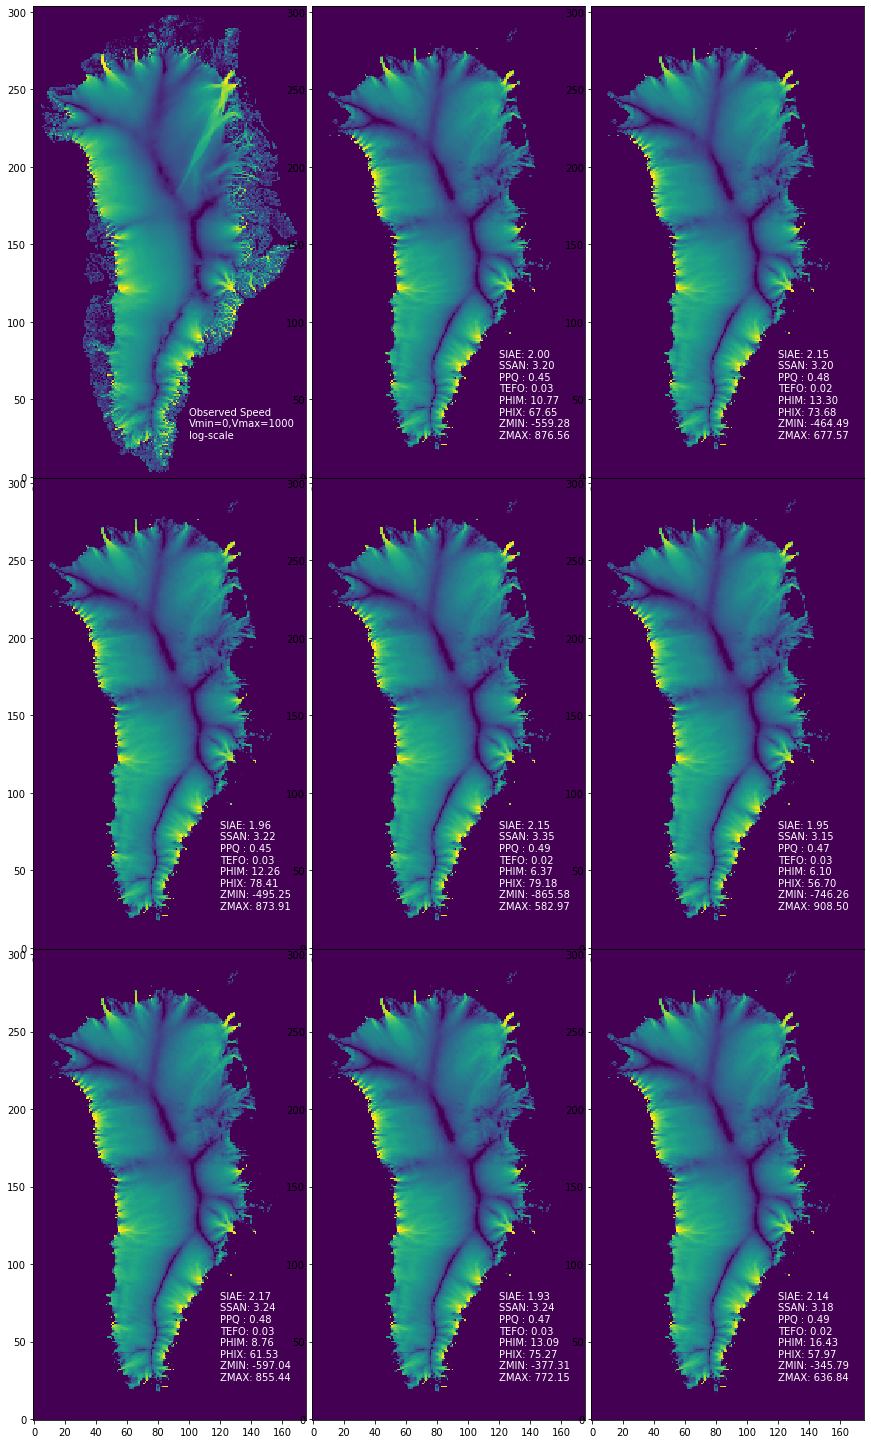

In [139]:
X_list = []

for model_index in range(n_models):
    X_list.append(np.load(open('./samples/X_posterior_model_{0:03d}.npy'.format(model_index),'rb')))
    
X_posterior = np.vstack(X_list)    
X_posterior = X_posterior*X_s.cpu().numpy() + X_m.cpu().numpy()

fig,axs = plt.subplots(nrows=3,ncols=3,figsize=(15,26))
axs = axs.ravel()
axs[0].imshow(np.log10(U_obs.detach().cpu().numpy().reshape((ny,nx))+1e-3),origin='lower',vmin=0,vmax=3)
axs[0].text(100,25,'Observed Speed\nVmin=0,Vmax=1000\nlog-scale',c='white')
for ax in axs[1:]:
    model_index = np.random.randint(10)
    sample_index = np.random.randint(9000)
    m = models[model_index]
    
    X_p = np.load(open('./samples/X_posterior_model_{0:03d}.npy'.format(model_index),'rb'))
    X_p_scaled = X_p*X_s.cpu().numpy() + X_m.cpu().numpy()   
    ax.imshow(m(torch.tensor(X_p[sample_index],device=device),add_mean=True).detach().cpu().numpy().reshape((ny,nx)),origin='lower',vmin=0,vmax=3)
    ax.text(120,25,'SIAE: {0:.2f}\nSSAN: {1:.2f}\nPPQ : {2:.2f}\nTEFO: {3:.2f}\nPHIM: {4:.2f}\nPHIX: {5:.2f}\nZMIN: {6:.2f}\nZMAX: {7:.2f}'.format(*X_p_scaled[sample_index]),c='white')
fig.subplots_adjust(wspace=0,hspace=0)
fig.savefig('emulator_speeds.pdf')

In [104]:
U_obs.detach().cpu().numpy().reshape((ny,nx)).shape

(304, 176)

In [108]:
dataset.return_original().cpu().numpy().min(axis=0)

NameError: name 'dataset' is not defined

TODO: Add plotting